<a href="https://colab.research.google.com/github/Animeshp43/Speech_Emotion_Recognition/blob/main/SER_CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/SER_Audio_Dataset"


Crema	     prepare_dataset  Savee  X_features.npy
New_dataset  Ravdess	      Tess   y_labels.npy


In [ ]:
!ls "/content/drive/MyDrive/SER_Audio_Dataset"


Crema  Ravdess	Savee  Tess


In [ ]:
!find "/content/drive/MyDrive/SER_Audio_Dataset/Crema" -type f | head
!find "/content/drive/MyDrive/SER_Audio_Dataset/Ravdess" -type f | head
!find "/content/drive/MyDrive/SER_Audio_Dataset/Savee" -type f | head
!find "/content/drive/MyDrive/SER_Audio_Dataset/Tess" -type f | head


/content/drive/MyDrive/SER_Audio_Dataset/Crema/1081_DFA_DIS_XX.wav
/content/drive/MyDrive/SER_Audio_Dataset/Crema/1080_WSI_ANG_XX.wav
/content/drive/MyDrive/SER_Audio_Dataset/Crema/1079_TAI_DIS_XX.wav
/content/drive/MyDrive/SER_Audio_Dataset/Crema/1079_DFA_NEU_XX.wav
/content/drive/MyDrive/SER_Audio_Dataset/Crema/1081_IEO_HAP_MD.wav
/content/drive/MyDrive/SER_Audio_Dataset/Crema/1079_TSI_NEU_XX.wav
/content/drive/MyDrive/SER_Audio_Dataset/Crema/1081_DFA_SAD_XX.wav
/content/drive/MyDrive/SER_Audio_Dataset/Crema/1081_DFA_ANG_XX.wav
/content/drive/MyDrive/SER_Audio_Dataset/Crema/1080_TIE_DIS_XX.wav
/content/drive/MyDrive/SER_Audio_Dataset/Crema/1079_TAI_NEU_XX.wav
/content/drive/MyDrive/SER_Audio_Dataset/Ravdess/audio_speech_actors_01-24/Actor_02/03-01-02-01-02-02-02.wav
/content/drive/MyDrive/SER_Audio_Dataset/Ravdess/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-02-02.wav
/content/drive/MyDrive/SER_Audio_Dataset/Ravdess/audio_speech_actors_01-24/Actor_02/03-01-01-01-02-02-02.wav
/co

In [ ]:
!pip install librosa soundfile numpy pandas scikit-learn matplotlib keras tensorflow


In [ ]:
import os

# Manually count all .wav files recursively
def count_audio_files(folder):
    count = 0
    for root, _, files in os.walk(folder):
        count += len([f for f in files if f.endswith(".wav")])
    return count

folders = {
    "Crema": "/content/drive/MyDrive/SER_Audio_Dataset/Crema",
    "Ravdess": "/content/drive/MyDrive/SER_Audio_Dataset/Ravdess/audio_speech_actors_01-24",
    "Savee": "/content/drive/MyDrive/SER_Audio_Dataset/Savee",
    "Tess": "/content/drive/MyDrive/SER_Audio_Dataset/Tess"
}

total = 0
for name, path in folders.items():
    count = count_audio_files(path)
    print(f"{name}: 🎧 {count} audio files found")
    total += count

print(f"\n📦 Total audio files across all datasets: {total}")


Crema: 🎧 7442 audio files found
Ravdess: 🎧 1440 audio files found
Savee: 🎧 480 audio files found
Tess: 🎧 2800 audio files found

📦 Total audio files across all datasets: 12162


In [ ]:
import os
import librosa
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Paths
crema_path = "/content/drive/MyDrive/SER_Audio_Dataset/Crema"
ravdess_path = "/content/drive/MyDrive/SER_Audio_Dataset/Ravdess/audio_speech_actors_01-24"
savee_path = "/content/drive/MyDrive/SER_Audio_Dataset/Savee"
tess_path = "/content/drive/MyDrive/SER_Audio_Dataset/Tess"

# Emotion Mappings
ravdess_emotions = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}

crema_emotions = {
    'NEU': 'neutral', 'HAP': 'happy', 'SAD': 'sad', 'ANG': 'angry',
    'FEA': 'fear', 'DIS': 'disgust'
}

savee_emotions = {
    'a': 'angry', 'd': 'disgust', 'f': 'fear',
    'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'surprise'
}

tess_emotions = {
    'angry': 'angry', 'disgust': 'disgust', 'fear': 'fear',
    'happy': 'happy', 'neutral': 'neutral',
    'pleasant_surprise': 'surprise', 'sad': 'sad'
}

# Constants
N_MFCC = 40
MAX_LEN = 173  # Number of time steps

# Store features and labels
features = []
labels = []
dataset_counts = defaultdict(int)

# Function to extract padded MFCC sequences
def extract_mfcc_sequence(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
    if mfcc.shape[1] > MAX_LEN:
        mfcc = mfcc[:, :MAX_LEN]
    mfcc_padded = pad_sequences([mfcc.T], maxlen=MAX_LEN, padding='post', dtype='float32')[0]
    return mfcc_padded

# --- RAVDESS ---
print("🔍 Processing Ravdess...")
for actor_folder in tqdm(sorted(os.listdir(ravdess_path))):
    actor_path = os.path.join(ravdess_path, actor_folder)
    for file in os.listdir(actor_path):
        if file.endswith(".wav"):
            emotion_code = file.split("-")[2]
            emotion = ravdess_emotions.get(emotion_code)
            if emotion:
                path = os.path.join(actor_path, file)
                features.append(extract_mfcc_sequence(path))
                labels.append(emotion)
                dataset_counts["Ravdess"] += 1

# --- CREMA-D ---
print("🔍 Processing Crema...")
for file in tqdm(sorted(os.listdir(crema_path))):
    if file.endswith(".wav"):
        parts = file.split('_')
        emotion_code = parts[2]
        emotion = crema_emotions.get(emotion_code)
        if emotion:
            path = os.path.join(crema_path, file)
            features.append(extract_mfcc_sequence(path))
            labels.append(emotion)
            dataset_counts["Crema"] += 1

# --- SAVEE ---
print("🔍 Processing Savee...")
for file in tqdm(sorted(os.listdir(savee_path))):
    if file.endswith(".wav"):
        file_name = file.split('.')[0]
        emo_code = file_name.split('_')[-1]
        matched = False
        for key in sorted(savee_emotions.keys(), key=lambda x: -len(x)):
            if emo_code.startswith(key):
                emotion = savee_emotions[key]
                path = os.path.join(savee_path, file)
                features.append(extract_mfcc_sequence(path))
                labels.append(emotion)
                dataset_counts["Savee"] += 1
                matched = True
                break
        if not matched:
            print(f"⚠️ Skipped SAVEe file: {file} (unknown emotion code)")

# --- TESS ---
print("🔍 Processing Tess...")
for folder in sorted(os.listdir(tess_path)):
    folder_path = os.path.join(tess_path, folder)
    if not os.path.isdir(folder_path):
        continue
    folder_lower = folder.lower().replace("-", "_")
    matched = False
    for key in tess_emotions:
        if key in folder_lower:
            emotion = tess_emotions[key]
            matched = True
            break
    if not matched:
        print(f"⚠️ Skipped folder: {folder}")
        continue
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            path = os.path.join(folder_path, file)
            features.append(extract_mfcc_sequence(path))
            labels.append(emotion)
            dataset_counts["Tess"] += 1

# Final arrays
X = np.array(features)
y = np.array(labels)

# Summary
print("\n📊 Dataset-wise Summary:")
for name, count in dataset_counts.items():
    print(f"{name}: ✅ {count} files loaded")
print(f"\n✅ Total files loaded: {len(X)}")
print(f"✅ Feature shape: {X.shape}")  # should be (samples, 173, 40)
print(f"✅ Label shape: {y.shape}")
print("\n🔎 Emotion label distribution:")
print(Counter(y))


🔍 Processing Ravdess...


100%|██████████| 24/24 [00:58<00:00,  2.43s/it]


🔍 Processing Crema...


100%|██████████| 7442/7442 [04:32<00:00, 27.27it/s]


🔍 Processing Savee...


100%|██████████| 480/480 [00:19<00:00, 25.14it/s]


🔍 Processing Tess...

📊 Dataset-wise Summary:
Ravdess: ✅ 1440 files loaded
Crema: ✅ 7442 files loaded
Savee: ✅ 480 files loaded
Tess: ✅ 2800 files loaded

✅ Total files loaded: 12162
✅ Feature shape: (12162, 173, 40)
✅ Label shape: (12162,)

🔎 Emotion label distribution:
Counter({np.str_('happy'): 1923, np.str_('sad'): 1923, np.str_('angry'): 1923, np.str_('disgust'): 1923, np.str_('fear'): 1923, np.str_('neutral'): 1703, np.str_('surprise'): 652, np.str_('calm'): 192})


In [4]:
import numpy as np

# Save features and labels
np.save("/content/drive/MyDrive/SER_Audio_Dataset/X_features.npy", X)
np.save("/content/drive/MyDrive/SER_Audio_Dataset/y_labels.npy", y)

print(" Features and labels saved successfully!")


 Features and labels saved successfully!


In [3]:
# Load features and labels
X = np.load("/content/drive/MyDrive/SER_Audio_Dataset/X_features.npy")
y = np.load("/content/drive/MyDrive/SER_Audio_Dataset/y_labels.npy")

print(" Loaded saved features and labels.")
print("X shape:", X.shape)
print("y shape:", y.shape)


 Loaded saved features and labels.
X shape: (12162, 173, 40)
y shape: (12162,)


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()

# CNN layers
model.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=(173, 40)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Dense output
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 169, 128)       │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 169, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 84, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 84, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 82, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 82, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,840 (347.03 KB)

 Trainable params: 88,456 (345.53 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.1634 - loss: 1.9709 - val_accuracy: 0.2137 - val_loss: 1.8856 - learning_rate: 0.0010
Epoch 2/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 44s 91ms/step - accuracy: 0.2218 - loss: 1.8407 - val_accuracy: 0.3465 - val_loss: 1.6003 - learning_rate: 0.0010
Epoch 3/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - accuracy: 0.3292 - loss: 1.6110 - val_accuracy: 0.4180 - val_loss: 1.4214 - learning_rate: 0.0010
Epoch 4/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.4143 - loss: 1.4465 - val_accuracy: 0.4875 - val_loss: 1.3197 - learning_rate: 0.0010
Epoch 5/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.4685 - loss: 1.3287 - val_accuracy: 0.5179 - val_loss: 1.2030 - learning_rate: 0.0010
Epoch 6/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.5269 - loss: 1.2062 - val_accuracy: 0.5573 - val_loss: 1.1412 - learning_rate: 0.0010
Epoch 7/100
305/305 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.5

In [ ]:
# Evaluate Train Accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"✅ Train Accuracy: {train_acc:.2%}")

# Evaluate Test Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.2%}")



✅ Train Accuracy: 80.92%
✅ Test Accuracy: 67.28%


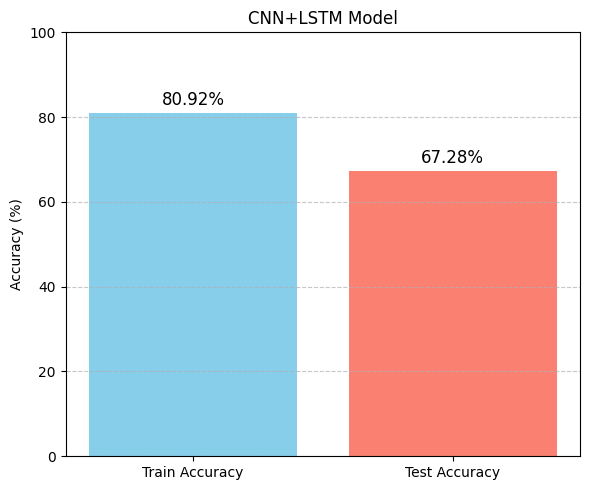

In [7]:
import matplotlib.pyplot as plt

# Define the accuracies
train_accuracy = 80.92
test_accuracy = 67.28

# Labels and values
labels = ['Train Accuracy', 'Test Accuracy']
accuracies = [train_accuracy, test_accuracy]

# Plotting
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, accuracies, color=['skyblue', 'salmon'])

# Annotate values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12)

# Title and labels
plt.title('CNN+LSTM Model')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# Save model in HDF5 format
model.save("cnn_lstm_ser1_model.h5")
print("✅ Model saved successfully as cnn_lstm_ser_model.h5")


✅ Model saved successfully as cnn_lstm_ser_model.h5


In [ ]:
import shutil

# Move to Google Drive folder
shutil.move("cnn_lstm_ser1_model.h5", "/content/drive/MyDrive/cnn_lstm_ser_model.h5")
print("✅ Model uploaded to Google Drive.")



✅ Model uploaded to Google Drive.


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load model
model = load_model("/content/drive/MyDrive/cnn_lstm_ser_model.h5")

# Load features, labels
X = np.load("/content/drive/MyDrive/SER_Audio_Dataset/X_features.npy")
y = np.load("/content/drive/MyDrive/SER_Audio_Dataset/y_labels.npy")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_map = dict(zip(le.classes_, range(len(le.classes_))))
id2label = dict(zip(range(len(le.classes_)), le.classes_))


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

# Initialize
features = []
labels = []
meta = []
dataset_counts = {"Ravdess": 0, "Crema": 0, "Savee": 0, "Tess": 0}

# Emotion mapping
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

def extract_mfcc_sequence(path, max_len=173):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.T

# Dataset paths
base_path = "/content/drive/MyDrive/SER_Audio_Dataset"
ravdess_path = os.path.join(base_path, "Ravdess")
crema_path = os.path.join(base_path, "Crema")
savee_path = os.path.join(base_path, "Savee")
tess_path = os.path.join(base_path, "Tess")

# 🔁 RAVDESS (Only speech, not song)
for root, _, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            parts = file.split("-")
            if len(parts) == 7 and parts[1] == '01':  # '01' = speech, '02' = song
                emotion_code = parts[2]
                emotion = emotion_map.get(emotion_code)
                if emotion:
                    features.append(extract_mfcc_sequence(path))
                    labels.append(emotion)
                    meta.append({"filename": file, "source": "ravdess"})
                    dataset_counts["Ravdess"] += 1

# 🔁 CREMA-D
for file in os.listdir(crema_path):
    if file.endswith(".wav"):
        path = os.path.join(crema_path, file)
        parts = file.split("_")
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = {
                'ANG': 'angry', 'DIS': 'disgust', 'FEA': 'fearful', 'HAP': 'happy',
                'NEU': 'neutral', 'SAD': 'sad'
            }.get(emotion_code)
            if emotion:
                features.append(extract_mfcc_sequence(path))
                labels.append(emotion)
                meta.append({"filename": file, "source": "crema"})
                dataset_counts["Crema"] += 1

# 🔁 SAVEE (fixed for filename format like DC_a04.wav)
for file in os.listdir(savee_path):
    if file.endswith(".wav"):
        path = os.path.join(savee_path, file)
        parts = file.split('_')
        if len(parts) >= 2:
            code = parts[1][0].lower()  # get first character of the emotion code (e.g., 'a' in 'a04')
            emotion = {
                'a': 'angry', 'd': 'disgust', 'f': 'fearful',
                'h': 'happy', 'n': 'neutral', 's': 'sad', 'u': 'surprised', 'z': 'surprised'
            }.get(code)
            if emotion:
                features.append(extract_mfcc_sequence(path))
                labels.append(emotion)
                meta.append({"filename": file, "source": "savee"})
                dataset_counts["Savee"] += 1



# 🔁 TESS
for root, _, files in os.walk(tess_path):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            parts = file.split("_")
            if len(parts) >= 3:
                raw_emotion = parts[2].replace(".wav", "").lower()
                mapped = {
                    'angry': 'angry', 'disgust': 'disgust', 'fear': 'fearful',
                    'happy': 'happy', 'neutral': 'neutral', 'ps': 'surprised', 'sad': 'sad'
                }.get(raw_emotion)
                if mapped:
                    features.append(extract_mfcc_sequence(path))
                    labels.append(mapped)
                    meta.append({"filename": file, "source": "tess"})
                    dataset_counts["Tess"] += 1

# ✅ Convert to arrays and save
X = np.array(features)
y = np.array(labels)
meta_df = pd.DataFrame(meta)

np.save(os.path.join(base_path, "X_features.npy"), X)
np.save(os.path.join(base_path, "y_labels.npy"), y)
meta_df.to_csv(os.path.join(base_path, "ser_metadata.csv"), index=False)

print(" Features and labels saved.")
print(" Metadata saved as ser_metadata.csv.")
print(" Dataset counts:", dataset_counts)
print(" Total samples:", len(y))


 Features and labels saved.
 Metadata saved as ser_metadata.csv.
 Dataset counts: {'Ravdess': 1440, 'Crema': 7442, 'Savee': 480, 'Tess': 2800}
 Total samples: 12162


In [ ]:
import pickle

# Assuming you used this during preprocessing
from sklearn.preprocessing import LabelEncoder

# After label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save label encoder
with open("/content/drive/MyDrive/SER_Audio_Dataset/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ Label encoder saved.")


✅ Label encoder saved.


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle

# Load saved labels
y = np.load("/content/drive/MyDrive/SER_Audio_Dataset/y_labels.npy")

# Recreate label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y)

# Save it
with open("/content/drive/MyDrive/SER_Audio_Dataset/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ Label encoder recreated and saved.")


✅ Label encoder recreated and saved.


In [ ]:
import os
import librosa
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# Paths
model_path = "/content/drive/MyDrive/cnn_lstm_ser_model.h5"
encoder_path = "/content/drive/MyDrive/SER_Audio_Dataset/label_encoder.pkl"
audio_file_path = "/content/drive/MyDrive/SER_Audio_Dataset/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav"  # 🔁 Change this

# Load model and encoder
model = load_model(model_path)
with open(encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

# Extract MFCC
def extract_mfcc_sequence(path, max_len=173):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.T

# Load audio and preprocess
mfcc = extract_mfcc_sequence(audio_file_path)
mfcc = np.expand_dims(mfcc, axis=0)  # Add batch dimension

# Predict
y_pred_prob = model.predict(mfcc)
predicted_index = np.argmax(y_pred_prob)
predicted_label = label_encoder.inverse_transform([predicted_index])[0]

print("🎙️ Audio File:", os.path.basename(audio_file_path))
print("🔮 Predicted Emotion:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
🎙️ Audio File: 1001_IOM_HAP_XX.wav
🔮 Predicted Emotion: happy


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import pickle
from tensorflow.keras.models import load_model

# ✅ Define paths
base_path = "/content/drive/MyDrive/SER_Audio_Dataset"  # Correct path for label_encoder.pkl and datasets
model_path = "/content/drive/MyDrive/cnn_lstm_ser_model.h5"  # Path to the model

# === Load model and encoder ===
model = load_model(model_path)

with open(os.path.join(base_path, "label_encoder.pkl"), "rb") as f:
    label_encoder = pickle.load(f)


# === Dataset paths and counts ===
dataset_info = {
    "crema": {"path": os.path.join(base_path, "Crema"), "count": 7442},
    "ravdess": {"path": os.path.join(base_path, "Ravdess"), "count": 1440},
    "savee": {"path": os.path.join(base_path, "Savee"), "count": 480},
    "tess": {"path": os.path.join(base_path, "Tess"), "count": 2800}
}

def extract_mfcc_sequence(path, max_len=173):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.T

# === User input ===
dataset_name = input("Available datasets: ravdess, crema, savee, tess\nEnter dataset name: ").strip().lower()

if dataset_name not in dataset_info:
    print("❌ Invalid dataset name.")
else:
    dataset_path = dataset_info[dataset_name]["path"]
    max_index = dataset_info[dataset_name]["count"] - 1

    print(f"✅ Found {max_index + 1} samples in {dataset_name}.")
    sample_index = int(input(f"Enter sample number (0 to {max_index}): ").strip())

    if not (0 <= sample_index <= max_index):
        print("❌ Invalid sample number.")
    else:
        # Get all .wav files in sorted order
        audio_files = []
        for root, _, files in os.walk(dataset_path):
            wavs = sorted([os.path.join(root, f) for f in files if f.endswith(".wav")])
            audio_files.extend(wavs)

        audio_path = audio_files[sample_index]

        # Predict
        mfcc = extract_mfcc_sequence(audio_path)
        mfcc = np.expand_dims(mfcc, axis=0)
        prediction = model.predict(mfcc)
        predicted_emotion = label_encoder.inverse_transform([np.argmax(prediction)])[0]

        print(f"🎧 File: {os.path.basename(audio_path)}")
        print(f"🔮 Predicted Emotion: {predicted_emotion}")


Available datasets: ravdess, crema, savee, tess
Enter dataset name: tess
✅ Found 2800 samples in tess.
Enter sample number (0 to 2799): 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
🎧 File: OAF_bath_fear.wav
🔮 Predicted Emotion: fearful
